In [86]:
from models import ReLog
from torch import nn
import torch
import numpy as np
import math

# Kaiming initialization (PyTorch's default)

In [15]:
x = torch.randn(3, 10)

In [16]:
x.mean(), x.std()

(tensor(0.3269), tensor(0.7713))

In [17]:
y = x
print(y.std(axis=0).mean().item())
for _ in range(20):
    block = nn.Sequential(nn.Linear(10, 10), ReLog(10))
    y = block(y)
    print(y.std(axis=0).mean().item())

0.8282634019851685
0.2579179108142853
0.18509939312934875
0.10574058443307877
0.07564598321914673
0.05287020653486252
0.04194851592183113
0.052657127380371094
0.027847927063703537
0.016833871603012085
0.014422503300011158
0.0077165463007986546
0.0011162039590999484
0.0015166124794632196
0.000737894733902067
0.0005017300136387348
0.0003336876688990742
0.00012497641728259623
8.003566472325474e-05
5.858149233972654e-05
4.4255903048906475e-05


In [18]:
y

tensor([[0.3678, 0.3867, 0.6335, 0.0000, 0.6515, 0.0000, 0.3275, 0.0000, 0.3721,
         0.5382],
        [0.3677, 0.3865, 0.6335, 0.0000, 0.6515, 0.0000, 0.3275, 0.0000, 0.3722,
         0.5381],
        [0.3677, 0.3865, 0.6335, 0.0000, 0.6515, 0.0000, 0.3275, 0.0000, 0.3722,
         0.5381]], grad_fn=<AddBackward0>)

We can see clearly that standard deviation of neurons gradually goes down to zero and the activation of some neurons is also zero. This makes training super hard.

# Measure variance empirically

In [19]:
from torch.nn import functional as F
relog = lambda x, n: torch.log(F.relu(x) + 1/n) / math.log(n) + 1

In [20]:
std_x = np.linspace(1, 5, 100)

In [21]:
ys = [relog(torch.randn(100)*s, 10) for s in std_x]

In [22]:
std_y = np.array([y.std() for y in ys])

In [23]:
math.sqrt(1/std_y[0])

1.4891515277946568

In [24]:
ey = np.array([y.mean() for y in ys])

In [29]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

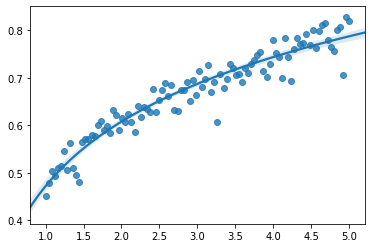

In [30]:
_ = sns.regplot(std_x, std_y, logx=True)

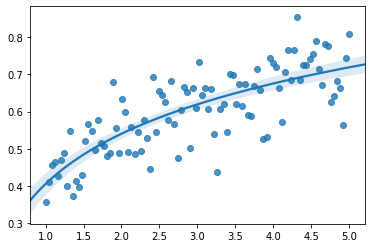

In [31]:
_ = sns.regplot(std_x, ey, logx=True)

In [34]:
np.poly1d(np.polyfit(np.log(std_x), ey, 1))

poly1d([0.19510145, 0.40494658])

In [35]:
math.sqrt(1 / (0.26271359 + 0.19558362))

1.4771561035924354

# Modified Kaiming initialization

In [36]:
x = torch.randn(100, 10)

In [46]:
class PreRelogLinear(nn.Linear):

    def __init__(self, *args, **kwargs):
        assert kwargs.get('bias', True), 'You need bias for ReLog'
        super(PreRelogLinear, self).__init__(*args, **kwargs)
        
    def reset_parameters(self):
        # not sure why this one works...
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
        bound = 1 / math.sqrt(fan_in)
        nn.init.normal_(self.weight, mean=0.5*bound, std=bound)
        nn.init.constant_(self.bias, -0.05)

In [47]:
y = x
# print(y.std(axis=0).mean().item())
for _ in range(20):
    block = nn.Sequential(PreRelogLinear(10, 10), ReLog(10))
    y = block(y)
    stds = y.std(axis=0)
    print(stds.mean().item(), stds.std().item())
    print(y[:3])    

0.4926929473876953 0.048302870243787766
tensor([[0.0000, 1.0122, 1.0587, 0.8433, 1.0886, 0.6173, 0.0000, 0.9126, 0.0000,
         0.7370],
        [0.0000, 0.9234, 0.0000, 0.0000, 0.8693, 0.2563, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.7673, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]], grad_fn=<SliceBackward>)
0.35734933614730835 0.10747861862182617
tensor([[1.2632, 1.0940, 1.0877, 1.2019, 0.0000, 1.0846, 0.7682, 0.6748, 1.2964,
         0.7907],
        [0.6914, 0.8649, 0.7151, 0.3306, 0.0000, 0.2248, 0.0000, 0.2587, 0.6377,
         0.0000],
        [0.3555, 0.3485, 0.4945, 0.0000, 0.3804, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]], grad_fn=<SliceBackward>)
0.2195490300655365 0.05195534601807594
tensor([[1.1945, 1.3165, 0.0000, 1.1247, 1.0763, 0.9720, 1.0493, 1.4472, 1.3402,
         1.0912],
        [0.9226, 0.8703, 0.0000, 0.4660, 0.7337, 0.5095, 0.5636, 1.1054, 0.9235,
         0.5858],
        [0.4508, 0.4829, 0.0000, 0.17

In [514]:
modules2 = []
for i in range(100):
    modules2 += [
        PreRelogLinear(10, 10),
        ReLog(10),
    ]
net2 = nn.Sequential(*modules2)

In [515]:
y2 = net2(x)

In [ ]:
y2[:3]

In [517]:
y2.std(axis=0)

tensor([0.2637, 0.2295, 0.2460, 0.1103, 0.2811, 0.0000, 0.2619, 0.2639, 0.2357,
        0.2686], grad_fn=<StdBackward1>)

In [518]:
y2.mean(axis=0)

tensor([1.8363, 1.5983, 1.7133, 0.7685, 1.9577, 0.0000, 1.8244, 1.8382, 1.6416,
        1.8708], grad_fn=<MeanBackward1>)

# Test my models

In [1]:
from models import VGG
import torch

In [2]:
net = VGG()

In [3]:
x = torch.randn(1000, 3, 32, 32)

In [5]:
%%time
y = net(x)

CPU times: user 7.25 s, sys: 684 ms, total: 7.93 s
Wall time: 7.95 s


In [5]:
y.mean(), y.std()

(tensor(-0.2280, grad_fn=<MeanBackward0>),
 tensor(0.6622, grad_fn=<StdBackward0>))

In [9]:
y

tensor([[-0.7105,  1.0011, -0.8515,  ...,  1.0227,  0.0399,  0.9728],
        [-0.3577,  1.1139, -0.9156,  ...,  0.1364, -0.1879,  1.4747],
        [ 0.1463,  1.4890, -0.9308,  ...,  0.1673, -0.1510,  1.1881],
        ...,
        [-0.4688,  0.5950, -1.1040,  ...,  1.2701,  0.3161,  1.3036],
        [-0.5111,  1.2565, -1.4919,  ...,  0.5230, -0.1460,  1.1186],
        [ 0.0141,  0.8745, -0.8306,  ...,  0.3521, -0.0053,  1.4087]],
       grad_fn=<AddmmBackward>)